In [2]:
import twobitreader as tbr
import time
import gzip
import shutil
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
#Loading Reference Genome
gen_file = '../data/hg19.2bit'
genome = tbr.TwoBitFile(gen_file)

In [3]:
genome.sequence_sizes

<bound method TwoBitFile.sequence_sizes of {'chr1': <twobitreader.TwoBitSequence object at 0x11b425240>, 'chr2': <twobitreader.TwoBitSequence object at 0x11b425278>, 'chr3': <twobitreader.TwoBitSequence object at 0x119cb90f0>, 'chr4': <twobitreader.TwoBitSequence object at 0x11b4252b0>, 'chr5': <twobitreader.TwoBitSequence object at 0x11b4252e8>, 'chr6': <twobitreader.TwoBitSequence object at 0x11b425320>, 'chr7': <twobitreader.TwoBitSequence object at 0x11b4253c8>, 'chrX': <twobitreader.TwoBitSequence object at 0x11b425400>, 'chr8': <twobitreader.TwoBitSequence object at 0x11b425438>, 'chr9': <twobitreader.TwoBitSequence object at 0x11b425470>, 'chr10': <twobitreader.TwoBitSequence object at 0x11b4254a8>, 'chr11': <twobitreader.TwoBitSequence object at 0x11b4254e0>, 'chr12': <twobitreader.TwoBitSequence object at 0x11b425518>, 'chr13': <twobitreader.TwoBitSequence object at 0x11b425550>, 'chr14': <twobitreader.TwoBitSequence object at 0x11b425588>, 'chr15': <twobitreader.TwoBitSequenc

In [9]:
#Loading PXR Chip Data
NR_file = '../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz'
names = ['chrom', 'chromstart', 'chromend', 'name', 'score', 'strand', 'thickstart', 'thickend', 'itemrgb', 'blockcount' ]
NRBed = pd.read_table(NR_file, compression = 'gzip', names = names)
NRBed['chrom'] = NRBed['chrom'].astype('str')

In [12]:
#Creating File of Sequences for MEME-Chip Bash Script
filePath = '../data/NR_NarrowPeaks/CARSeqs.fasta'
motarr = NRBed.values
f = open(filePath, 'w+')
for i in motarr:
    f.write('>chr' + str(i[0]) + ':' + str(i[1]) + '-' + str(i[2]) + '\n' + 
            (genome[i[0]][i[1]:i[2]]).upper() + '\n')
with open(filePath, 'rb') as f_in, gzip.open(filePath + '.gz', 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)
f.close()


In [20]:
%%bash
#will take Nearly a day to run
homeDir=/Users/omarkana/Documents/sudin_pipeline/data
wkPath=./tmp-$RANDOM
dataPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/CARSeqs.fasta
outputPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/motif_discovery

#INSTALL MEME Suite (You will need to check the dependencies on http://meme-suite.org/doc/install.html?man_type=web also will need to check perl dependencies)
cd $homeDir
mkdir -p $wkPath
cd  $wkPath
wget http://meme-suite.org/meme-software/5.0.5/meme-5.0.5.tar.gz
tar -zxf meme-5.0.5.tar.gz
cd meme-5.0.5
./configure --prefix=$HOME/meme --with-url=http://meme-suite.org/ --enable-build-libxml2 --enable-build-libxslt
make
make test
make install
export export PATH=$HOME/meme/bin:$PATH 
cd ../

#Get Hocomoco database to get relationships
wget http://hocomoco11.autosome.ru/final_bundle/hocomoco11/core/HUMAN/mono/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme

#Look at Doc @ http://meme-suite.org/doc/overview.html?man_type=web for more info on specifications
#I took out the centrimo-local parameter for speed reasons. 
meme-chip -o $outputPath -dna -meme-nmotifs 5 -dreme-e 0.01 -centrimo-local -db HOCOMOCOv11_core_HUMAN_mono_meme_format.meme* $dataPath

#copy relevant contents and delete
cd $homeDir
rm -rf $wkPath

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

--2019-03-29 13:50:36--  http://meme-suite.org/meme-software/5.0.5/meme-5.0.5.tar.gz
Resolving meme-suite.org (meme-suite.org)... 54.202.109.29
Connecting to meme-suite.org (meme-suite.org)|54.202.109.29|:80... connected.
HTTP request sent, awaiting response... 200 
Length: 36560203 (35M) [application/x-gzip]
Saving to: ‘meme-5.0.5.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  323K 1m50s
    50K .......... .......... .......... .......... ..........  0%  537K 88s
   100K .......... .......... .......... .......... ..........  0% 20.9M 59s
   150K .......... .......... .......... .......... ..........  0%  481K 63s
   200K .......... 

In [ ]:
%%bash
##INSTALLATION Script for HOMER
#Parameters
wkPath=/Users/omarkana/Documents/sudin_pipeline/data/HOMER

#INSTALL HOMER (You will need to check the dependencies on http://homer.ucsd.edu/homer/introduction/install.html)
#Make sure to edit your ~/.bash_profile and add PATH=$PATH:$wkPath (see instruction from website above)
mkdir -p $wkPath
cd  $wkPath

wget http://homer.ucsd.edu/homer/configureHomer.pl
perl configureHomer.pl -install 
echo "PATH="$PATH":"$wkPath >> ~/.bash_profile
source ~/.bash_profile

In [1]:
%%bash
##Use Homer on Custom Fasta file (there is a way to use a bigWig file if you have a reference genome using findMotifsGenome.pl found here http://homer.ucsd.edu/homer/motif/index.html)
wkPath=/Users/omarkana/Documents/sudin_pipeline/data
dataPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/CARSeqs.fasta
outputPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/homer_discovery

cd $wkPath
#The longer the motifs you are looking for, the longer this will take. This is semi-parallelizable with -p
findMotifs.pl $dataPath fasta $outputPath -len 3,4,5,6,7,8 -S 20 

bash: line 8: findMotifs.pl: command not found


CalledProcessError: Command 'b'##Use Homer on Custom Fasta file (there is a way to use a bigWig file if you have a reference genome using findMotifsGenome.pl found here http://homer.ucsd.edu/homer/motif/index.html)\nwkPath=/Users/omarkana/Documents/sudin_pipeline/data\ndataPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/CARSeqs.fasta\noutputPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/homer_discovery\n\ncd $wkPath\n#The longer the motifs you are looking for, the longer this will take. This is semi-parallelizable with -p\nfindMotifs.pl $dataPath fasta $outputPath -len 4,5,6,7,8 -S 20 \n'' returned non-zero exit status 127.

In [8]:
#Finding Putative Binding Sites Using Motifs and then Visualize them

import twobitreader as tbr
import time
import gzip
import shutil
import pandas as pd
import numpy as np
import re
from Bio import SeqIO
from itertools import islice
import matplotlib.pyplot as plt

#Improvement TODO:
#I might make a fasta2twobit function in python later
#See if MEME can be incorporated into python
#probably  want to make a sequence class, pfm class, pwm class and peaks class to professionalize the code
#Fix the gzip problem
#Parallelize PWM Peak Search

#Lets start with devloping functions for reading pertinent files

#generate sequences in fasta and 2bit using biopython and twobitreader
#Don't use with gzipped files (It will unzip genome for every sequence)
#I'm going to use this function tbr to generate my sequences and revise my code
def genSeq(genome_path, chrom, chromstart, chromend):
    if bool(re.search('gz', genome_path)) | bool(re.search('fa', genome_path)) | bool(re.search('fasta', genome_path)):
        if bool(re.search('gz', genome_path)) == True:
            genome = SeqIO.parse(gzip.open(genome_path, 'rt'),'fasta')
            identifiers = [seq_record.id for seq_record in genome]
            seq_gen = next(islice(genome, identifiers.index(chrom) , None))
            seq = str(seq_gen.seq[chromstart:chromend])
        else:
            genome = SeqIO.parse(open(genome_path),'fasta')
            identifiers = [seq_record.id for seq_record in genome]
            seq_gen = next(islice(genome, identifiers.index(chrom) , None))
            seq = str(seq_gen.seq[chromstart:chromend])
    elif bool(re.search('2bit', genome_path)):
        tbGenome = tbr.TwoBitFile(genome_path)
        seq = tbGenome[chrom][chromstart:chromend]
    else:
        raise Exception('File type not recognized')
    return seq

#This function will make a MEME-Chip and Homer ready fasta file for de novo motif searches
#Peaks is a path for your bed file or Narrow or Broad Peak file
#output is a output path
#The reference genome should be in twobit format (As of 2019, UCSC has twobit for most model organisms).
#This keeps the program lightweight and allows for way less memory usage. For more info click here (https://genome.ucsc.edu/goldenpath/help/twoBit.html)
#Revise with genSeq
def peak2fasta(peaks, twobitgenome, output):
    if bool(re.search('.gz', peaks)):
        peakLoci = pd.read_table(peaks, compression = 'gzip', header = None)
    else:
        peakLoci = pd.read_table(peaks, header = None)
    genome = tbr.TwoBitFile(twobitgenome)
    peakLoci.iloc[:, 1] = peakLoci.iloc[:, 1].astype('str')
    motarr = peakLoci.values
    f = open(output, 'w+')
    for i in motarr:
        f.write('>chr' + str(i[0]) + ':' + str(i[1]) + '-' + str(i[2]) + '\n' + 
                (genome[i[0]][i[1]:i[2]]).upper() + '\n')
    f.close()
    return "done writing file"

#path is a generic pfm path 
#Maybe expand to different motif formats
def read_pfm(path):
    pfm = []
    with open(path) as f:
        for line in f:
            if line.startswith('>'):
                continue
            elif re.match('^[A,C,T,G]', line):
                print('FileError: Wrong File Type')
            else:
                nuc_freqs = list(line.split())
                pfm.append(nuc_freqs)
    return np.asarray(pfm).astype(np.float)

#convert PFM to PWM
#bg is priors for all four nucleotides ACGT respectively
#pseudocount function for zero count positions
def pfm2pwm(pfm, pseudocount = 0.8, bg = [0.25, 0.25, 0.25, 0.25]):
    #chagnge into integer matrix
    pfm = np.trunc(pfm).astype(np.int)
    #Calculating Post Prob
    s = pseudocount
    bg_a = np.array(bg)
    bg_t = np.matrix(bg).transpose()
    N = np.sum(pfm[:,0])
    ppm = (pfm + (s*bg_t))/(N + s * np.sum(bg_a))
    #Calculate Weights
    norm_ppm = []
    for i in range(len(pfm)):
        norm = np.asarray(ppm[i]/(bg[i]/np.sum(bg_a))).reshape(-1)
        norm_ppm.append(norm.tolist())
    nppm = np.array(norm_ppm)
    pwm = np.log2(norm_ppm)
    return pwm

#One Hot Encoding Sequence
def oheSeq(DNAString):
    seq = DNAString.upper()
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in seq]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.append(letter)
    seq_ohe = np.asarray(OHE)
    return seq_ohe

#Creating Reverese Complements
def reverseComp(Seq):
    seq = Seq.upper()
    d = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    try:
        seq = seq[::-1]
        rc_seq = "".join([d[nuc] for nuc in seq])
    except KeyError:
        return "Not Viable DNA Seq"
    return rc_seq

#Search Sequence for sequence postion of DNA segments that match with a high enough score
def searchSeq(pwm, Seq, score, strand = '*', trim = 7):
    seqs = []
    Seq = Seq[trim:-trim]
    rc = reverseComp(Seq)
    #Normalize PWM
    max_score = sum([max(i) for i in pwm.T])
    min_score = sum([min(i) for i in pwm.T])
    n = len(pwm[0])
    unitScale = (pwm-(min_score/n))/(max_score-min_score)
    revUS = (pwm[:,::-1]-(min_score/n))/(max_score-min_score)
    #Chunk sequence into overlapping segments
    if strand == '*':
        chunks = [rc[i:i+n] for i in range(len(rc)-n)]
        chunks.extend([Seq[i:i+n] for i in range(len(Seq)-n)])
    elif strand == '+':
        chunks = [Seq[i:i+n] for i in range(len(Seq)-n)]
    elif strand == '-':
        chunks = [rc[i:i+n] for i in range(len(rc)-n)]
    for i in range(len(chunks)):
        OHESeq = oheSeq(chunks[i])
        seqScore = sum([np.matmul(OHESeq[j], unitScale[:,j]) for j in range(len(chunks[i]))])
        revSeqScore = sum([np.matmul(OHESeq[j], revUS[:,j]) for j in range(len(chunks[i]))])
        if seqScore >= score:
            seqs.append([chunks[i], seqScore, i-len(Seq), 'Forward'])
        if revSeqScore >= score:
            seqs.append([chunks[i], revSeqScore, i-len(Seq), 'Reverse'])
    seqs = np.array(seqs)
    if len(seqs) > 0:
        names = ['Sequence', 'Score', 'Pos', 'Orient']
        return pd.DataFrame(seqs, columns=names)
    else:
        return seqs

#Parallelizable searchSeq for ChipSeq using UCSC 2bit reader
#If you are having errors involving indexing, make sure you are using the right organism and version of your genome
#revise with genseq (will reduce the program length immensely)
def searchPeaks(pwm, peak_path, twobitgenome, score, strand = '*', threads = 1):
    names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
    motifDF = []
    motifQuant = []
    if re.match('$fa',twobitgenome) or re.match('$fasta', twobitgenome):
        return 'Convert to 2bit: go to https://genome.ucsc.edu/goldenpath/help/twoBit.html for more info'
    genome = tbr.TwoBitFile(twobitgenome)
    if threads == 1:
        if bool(re.search('gz', peak_path)):
            with gzip.open(peak_path, 'rb') as f:
                for line in f:
                    line = line.decode('utf-8')
                    peak = list(line.split())
                    seq = (genome[peak[0]][int(peak[1]):int(peak[2])]).upper()
                    try:
                        seqs = searchSeq(pwm, seq, score)
                    except KeyError:
                        continue
                    if len(seqs) > 0:
                        seqs['chrom'] = peak[0]
                        seqs['chromstart'] = peak[1]
                        seqs['chromend'] = peak[2]
                        motifDF.append(seqs)
                        motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
        else:
            with open(peak_path) as f:
                for line in f:
                    peak = list(line.split())
                    seq = (genome[peak[0]][int(peak[1]):int(peak[2])]).upper()
                    try:
                        seqs = searchSeq(pwm, seq, score)
                    except KeyError:
                        continue
                    if len(seqs) > 0:
                        seqs['chrom'] = peak[0]
                        seqs['chromstart'] = peak[1]
                        seqs['chromend'] = peak[2]
                        motifDF.append(seqs)
                        motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
    else:
        return "Not Ready Yet"
    return pd.concat(motifDF), pd.DataFrame(motifQuant, columns= names)

#Genereate random sequences of length n
def randSeq(n, letters = 'ACGT'):
    code = dict((x,y) for x,y in enumerate(letters))
    encoded = np.random.randint(4, size = n)
    decode =  "".join([code[i] for i in encoded])
    return decode

#modified OHE for interspaced regions
def oheSeqMod(DNAString, flank_len):
    seq = DNAString.upper()
    flanks = seq[:6+flank_len] + seq[-6-flank_len:]
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in flanks]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.extend(letter)
    OHE.append(len(seq[6+flank_len:-6-flank_len]))
    return OHE


#Traditional PWM Search
#Takes a while currently
'''
search, dist = searchPeaks(pwm, '../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', '../data/mm10.2bit', 0.8, threads=1)
'''

#Regex Search
#Might want to combine with PWM here to explore larger Binding Site Space
'''
DR = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,10}?[AG]G[GT]TCA[AGCT]{5}'
IR = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,10}?ACT[GT]G[AG][AGCT]{5}'
ER1 = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,10}?[AG]G[GT]TCA[AGCT]{5}'
ER2 = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,10}?ACT[GT]G[AG][AGCT]{5}'
regBS = re.compile("(%s|%s|%s|%s)" % (DR,IR,ER1,ER2))
motifDF = []
motifQuant = []
genome = tbr.TwoBitFile('../data/mm10.2bit')
with gzip.open('../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', 'rb') as f:
    for line in f:
        line = line.decode('utf-8')
        peak = list(line.split())
        seq = (genome[peak[0]][int(peak[1]):int(peak[2])]).upper()
        rSeq = reverseComp(seq)
        sequences = []
        for result in re.finditer(regBS, seq):
            sequences.append("".join(result.groups()))
        for result in re.finditer(regBS, rSeq):
            sequences.append("".join(result.groups()))
        if len(sequences) > 0:
            seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2]})
            motifDF.append(seqs)
            motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
search_reg = pd.concat(motifDF)
names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
dist_reg = pd.DataFrame(motifQuant, columns=names)
n = 5
x = [len(i[6+n:-6-n]) for i in search_reg['binding']]
'''

#Dimensionality Reductions
'''
#euc for euclidean

euc_ohe =  np.array([oheSeqMod(i, 5) for i in search_reg['binding']])
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap  
#Be careful with umap installation pip install umap will cause you to install the wrong ver of umap (and will also break the real module)

pca = PCA(n_components=2)
pca.fit(euc_ohe)
print(pca.explained_variance_ratio_)

#Takes a bit with larger datasets (scales n^2 in both compute time and memory)
X_embedded = TSNE(n_components=2).fit_transform(euc_ohe)

#Also takes a bit (even though they claim it is faster than TSNE)
umapped = umap.UMAP().fit_transform(euc_ohe)
'''

#Graphing example
'''
dim1 = X_embedded[:, 0]
dim2 = X_embedded[:, 1]
plt.scatter(dim1, dim2)
plt.title("OHE Mod TSNE")
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()
'''
#Getting Motifs for each cluster
'''
from Bio.Seq import Seq
from Bio import motifs

#Finding the flanking sequence logo for each cluster
cluster1 = search_reg[search_reg['labels'] == 0].iloc[:,0]
cluster2 = search_reg[search_reg['labels'] == 1].iloc[:,0]
cluster3 = search_reg[search_reg['labels'] == 2].iloc[:,0]
cluster4 = search_reg[search_reg['labels'] == 3].iloc[:,0]

clusters = [cluster1, cluster2, cluster3, cluster4]
for i in range(len(clusters)):
    instances = []
    for seq in clusters[i]:
        instances.append(Seq(seq[:6+n] + seq[-6-n:]))
    m = motifs.create(instances)
    m.weblogo('../data/motif_cluster' + str(i) + '.png')
'''

"\nfrom Bio.Seq import Seq\nfrom Bio import motifs\n\n#Finding the flanking sequence logo for each cluster\ncluster1 = search_reg[search_reg['labels'] == 0].iloc[:,0]\ncluster2 = search_reg[search_reg['labels'] == 1].iloc[:,0]\ncluster3 = search_reg[search_reg['labels'] == 2].iloc[:,0]\ncluster4 = search_reg[search_reg['labels'] == 3].iloc[:,0]\n\nclusters = [cluster1, cluster2, cluster3, cluster4]\nfor i in range(len(clusters)):\n    instances = []\n    for seq in clusters[i]:\n        instances.append(Seq(seq[:6+n] + seq[-6-n:]))\n    m = motifs.create(instances)\n    m.weblogo('../data/motif_cluster' + str(i) + '.png')\n"

In [9]:
peak2fasta('/Users/omarkana/Documents/sudin_pipeline/data/liver_euchormatin/ENCFF475HWF_Right_Lobe_Liver_DNASeq.bed.gz', "../data/hg38.2bit", "../data/liver_euchormatin/rightLobeLiverDNASeq/")

/Users/omarkana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


IsADirectoryError: [Errno 21] Is a directory: '../data/liver_euchormatin/rightLobeLiverDNASeq/'

In [506]:
search, dist = searchPeaks(pwm, '../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', '../data/mm10.2bit', 0.8, threads=1)

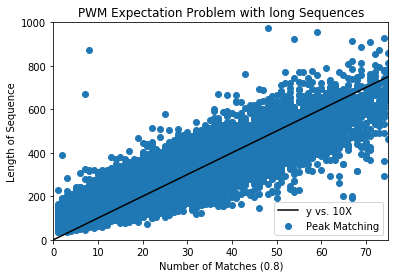

In [578]:
plt.scatter(dist['numOfMatches'], dist['lenSeq'], label = 'Peak Matching')
plt.xlabel('Number of Matches (0.8)')
plt.ylabel('Length of Sequence')
plt.xlim([0,75])
plt.ylim([0, 1000])
y = np.linspace(0, 1000, 200)
plt.plot(y/10, y, color = 'black', label = 'y vs. 10X')
plt.legend(loc = 'lower right')
plt.title('PWM Expectation Problem with long Sequences')
plt.show()

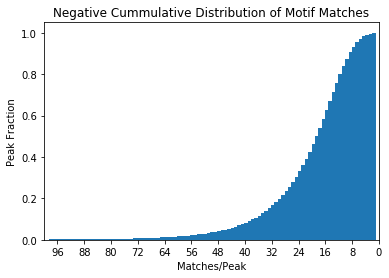

In [605]:
plt.hist(dist['numOfMatches'], bins=1000, density= True, cumulative=-1)
plt.title('Negative Cummulative Distribution of Motif Matches')
plt.ylabel('Peak Fraction')
plt.xlabel('Matches/Peak')
plt.xlim([100,0])
plt.xticks(np.arange(0, 100, step = 8))
plt.show()

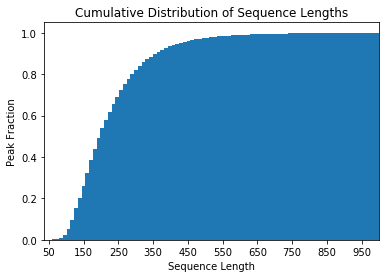

In [603]:
plt.hist(dist['lenSeq'], bins = 1000, density = True, cumulative=1)
plt.xlim([36, 1000])
plt.title('Cumulative Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Peak Fraction')
plt.xticks(np.arange(50,1000, step = 100))
plt.show()

In [3]:
#Finding Peaks using regex
#Make regex for RGKTCA
DR = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,8}?[AG]G[GT]TCA[AGCT]{5}'
IR = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,8}?ACT[GT]G[AG][AGCT]{5}'
ER1 = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,8}?[AG]G[GT]TCA[AGCT]{5}'
ER2 = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,8}?ACT[GT]G[AG][AGCT]{5}'
regBS = re.compile("(%s|%s|%s|%s)" % (DR,IR,ER1,ER2))
motifDF = []
motifQuant = []
genome = tbr.TwoBitFile('../data/mm10.2bit')
with gzip.open('../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', 'rb') as f:
    for line in f:
        line = line.decode('utf-8')
        peak = list(line.split())
        seq = (genome[peak[0]][int(peak[1]):int(peak[2])]).upper()
        rSeq = reverseComp(seq)
        sequences = []
        for result in re.finditer(regBS, seq):
            sequences.append("".join(result.groups()))
        for result in re.finditer(regBS, rSeq):
            sequences.append("".join(result.groups()))
        if len(sequences) > 0:
            seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2]})
            motifDF.append(seqs)
            motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
genome2 = tbr.TwoBitFile('../data/hg19.2bit')
with open('../data/NR_NarrowPeaks/1739Hamner_PPARa_ucsctracks.bed') as f:
    for line in f:
        if line.startswith('track') == False:
            peak = list(line.split())
            seq = (genome2[peak[0]][int(peak[1]):int(peak[2])]).upper()
            rSeq = reverseComp(seq)
            sequences = []
            for result in re.finditer(regBS, seq):
                sequences.append("".join(result.groups()))
            for result in re.finditer(regBS, rSeq):
                sequences.append("".join(result.groups()))
            if len(sequences) > 0:
                seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2], 'NR':'PPARA'})
                motifDF.append(seqs)
                motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
with open('../data/NR_NarrowPeaks/')
search_reg = pd.concat(motifDF)
names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
dist_reg = pd.DataFrame(motifQuant, columns=names)
n = 5
x = [len(i[6+n:-6-n]) for i in search_reg['binding']]

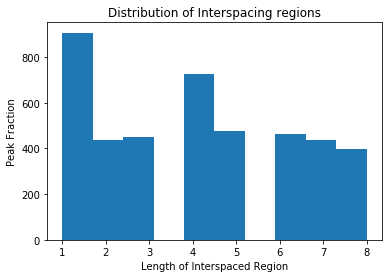

In [4]:
plt.hist(x)
plt.title('Distribution of Interspacing regions')
plt.ylabel('Peak Fraction')
plt.xlabel('Length of Interspaced Region')
plt.show()

In [5]:
len(search_reg['binding'].values.tolist())

4290

In [6]:
 from sklearn.decomposition import PCA

In [7]:
euc_ohe =  np.array([oheSeqMod(i, 5) for i in search_reg['binding']])
pca = PCA(n_components=2)
pca.fit(euc_ohe)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [8]:
print(pca.explained_variance_ratio_)

[0.31725998 0.08512923]


In [9]:
print(pca.singular_values_) 

[152.62917218  79.06226553]


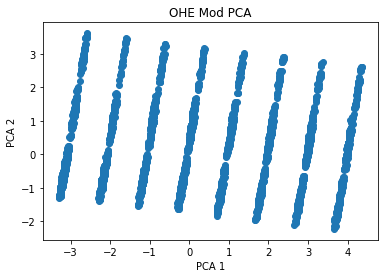

In [10]:
pca_coord = pca.transform(euc_ohe)
dim1 = pca_coord[:, 0]
dim2 = pca_coord[:, 1]
plt.scatter(dim1, dim2)
plt.title("OHE Mod PCA")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [11]:
from sklearn.manifold import TSNE

In [33]:
X_embedded = TSNE(n_components=2).fit_transform(euc_ohe)
X_embedded

array([[ 47.622845, -11.769926],
       [ 50.25029 , -17.972065],
       [ 24.42738 ,  21.748491],
       ...,
       [  6.420358,  21.505995],
       [ 52.449623,  10.902291],
       [-19.436672,  37.83114 ]], dtype=float32)

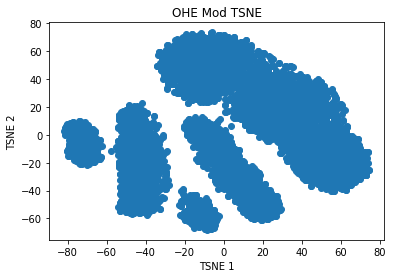

In [41]:
dim1 = X_embedded[:, 0]
dim2 = X_embedded[:, 1]
plt.scatter(dim1, dim2)
plt.title("OHE Mod TSNE")
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()

In [12]:
import umap

In [13]:
umapped = umap.UMAP().fit_transform(euc_ohe)
umapped

array([[ -9.413996  ,   2.075401  ],
       [ -9.108519  ,   2.5127487 ],
       [-10.512934  ,  -1.4091804 ],
       ...,
       [-10.784067  ,  -2.2691805 ],
       [ -9.700726  ,   0.41545448],
       [ -9.692617  ,  -4.8962708 ]], dtype=float32)

In [62]:
from sklearn.cluster import KMeans
labels = KMeans(n_clusters = 4).fit_predict(umapped)
search_reg['labels'] = labels
search_reg['interspace'] = x
search_reg.sort_values('labels')

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

In [64]:
from sklearn.cluster import SpectralClustering
labels = SpectralClustering(n_clusters=4).fit(umapped)
search_reg['labels'] = labels.labels_
search_reg['interspace'] = x
search_reg.sort_values('labels') 

,binding,chrom,chromstart,chromend,labels,interspace
0,GGTGAAGGTCAGGAAGCAAAGTTCAATTTT,chr1,3423275,3423472,0,8
0,GGAGTAGGTCAAAGGTCAAAGGC,chr2,167691985,167692520,0,1
0,CAGAAAGGTCAGGAGTTCAAGGTT,chr2,167693521,167694053,0,2
0,GGAAGGGGTCAGCCGGTTCAGTAAA,chr2,167764985,167765609,0,3
0,GTGTGAGGTCAGGATCTAGGGTTCAGGGAG,chr2,167853215,167853958,0,8
0,CTCTGACTTGAGCTGAGGAGAGGTTCACCCCG,chr2,167856950,167857214,0,10
0,GTCACGGTTCAAAGGTCATCCTC,chr2,168105329,168105648,0,1
0,ACAGCAGGTCACAGCAGGTCACAGCA,chr2,168347180,168347317,0,4
0,ACCTGAGTTCAAGCCCTGGAGTTCACACAG,chr2,170048863,170049132,0,8
0,TGGAGGGTTCAGGCAGCCTCGGGTCACCAGG,chr2,170454029,170454359,0,9


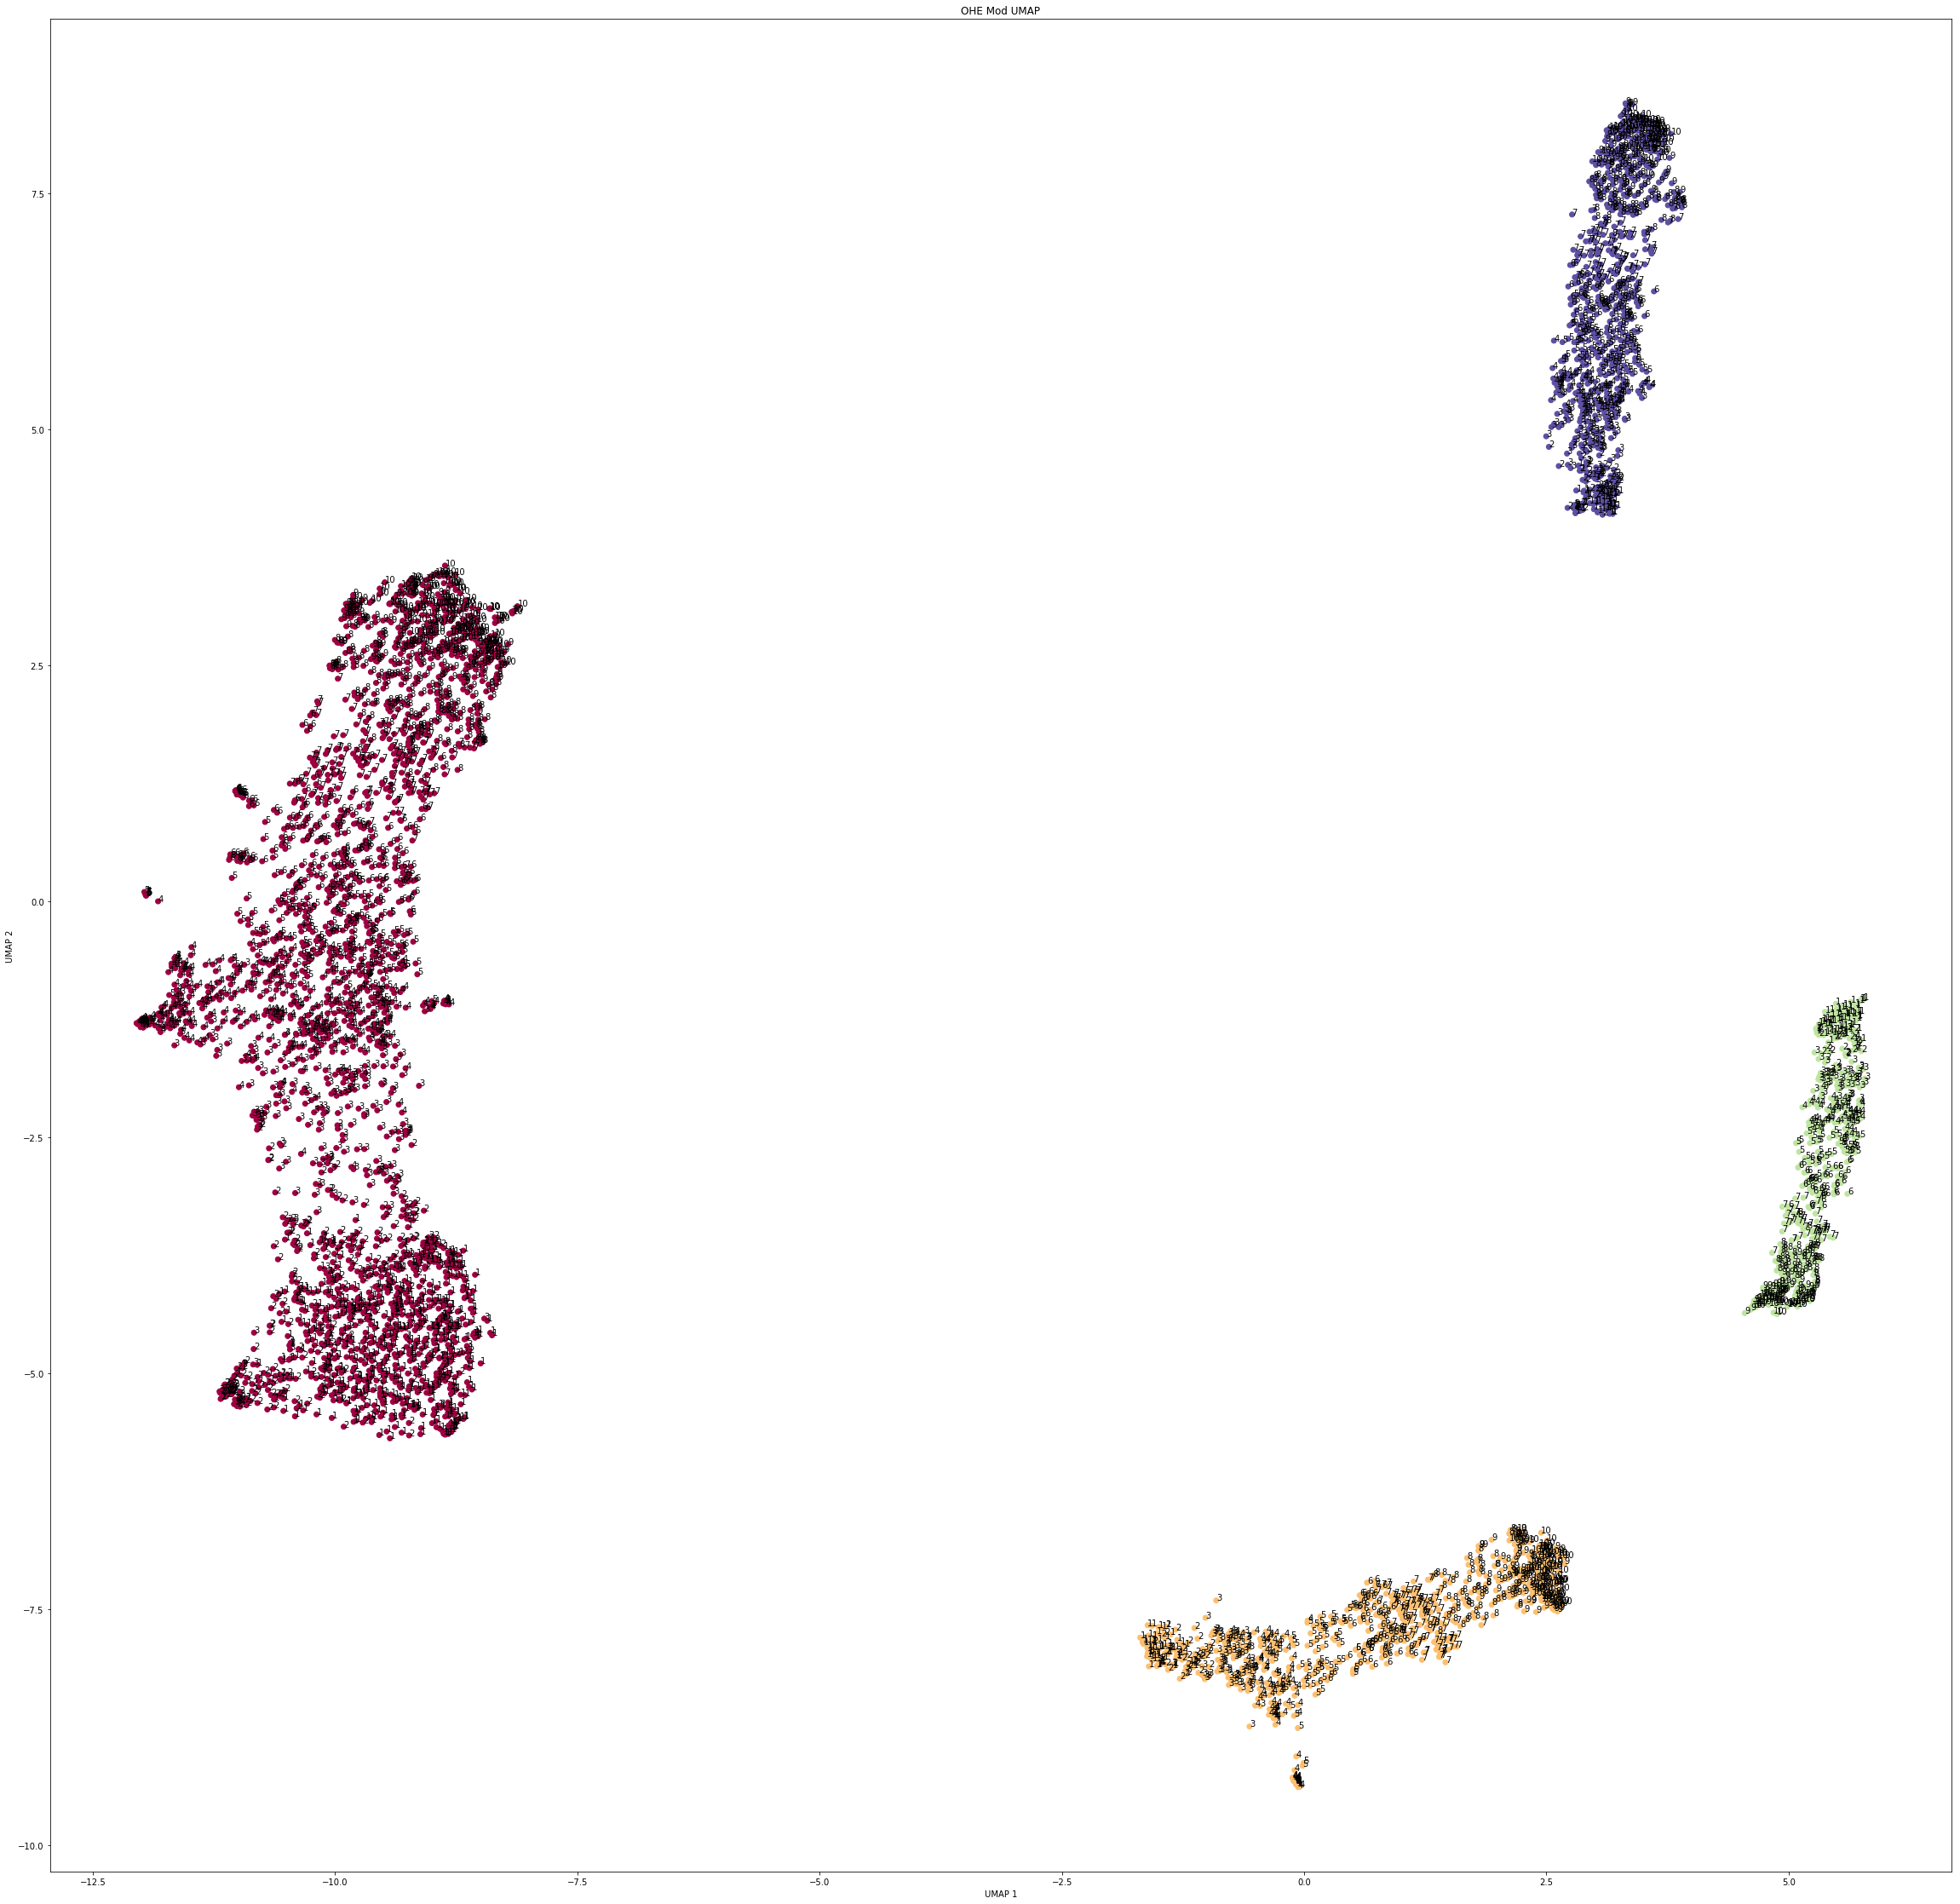

In [67]:
plt.figure(figsize=[40,40])
dim1 = umapped[:, 0]
dim2 = umapped[:, 1]
plt.scatter(dim1, dim2, c = labels.labels_, cmap = 'Spectral')
for i in range(len(x)):
    plt.text(dim1[i], dim2[i], str(x[i]))
plt.title("OHE Mod UMAP")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [68]:
from Bio.Seq import Seq
from Bio import motifs

In [69]:
#Finding the flanking sequence logo for each cluster
cluster1 = search_reg[search_reg['labels'] == 0].iloc[:,0]
cluster2 = search_reg[search_reg['labels'] == 1].iloc[:,0]
cluster3 = search_reg[search_reg['labels'] == 2].iloc[:,0]
cluster4 = search_reg[search_reg['labels'] == 3].iloc[:,0]

clusters = [cluster1, cluster2, cluster3, cluster4]
for i in range(len(clusters)):
    instances = []
    for seq in clusters[i]:
        instances.append(Seq(seq[:6+n] + seq[-6-n:]))
    m = motifs.create(instances)
    m.weblogo('../data/motif_cluster' + str(i) + '.png')

In [76]:
import pprint
pprint.pprint(m.counts)

{'A': [230,
       224,
       205,
       220,
       247,
       890,
       0,
       0,
       0,
       0,
       393,
       600,
       0,
       0,
       0,
       0,
       890,
       184,
       297,
       188,
       222,
       212],
 'C': [205,
       208,
       188,
       157,
       293,
       0,
       890,
       0,
       0,
       0,
       0,
       0,
       1,
       0,
       0,
       889,
       0,
       208,
       164,
       170,
       190,
       233],
 'G': [205,
       264,
       247,
       294,
       226,
       0,
       0,
       0,
       582,
       890,
       497,
       290,
       889,
       521,
       0,
       1,
       0,
       319,
       231,
       327,
       261,
       236],
 'T': [250,
       194,
       250,
       219,
       124,
       0,
       0,
       890,
       308,
       0,
       0,
       0,
       0,
       369,
       890,
       0,
       0,
       179,
       198,
       205,
       217,
       209]}


In [78]:
#Just Flanking sequence
for i in range(len(clusters)):
    instances = []
    for seq in clusters[i]:
        instances.append(Seq(seq[:n] + seq[-n:]))
    m = motifs.create(instances)
    m.weblogo('../data/flank_cluster' + str(i) + '.png')

In [10]:
genSeq('../data/est.fa.gz', 'I', 100000, 110000)

ValueError: 'I' is not in list